# Modeling and Simulation in Python

Chapter 13

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'
import pandas as np
from matplotlib import pyplot as plt
# import functions from the modsim.py module
from modsim import *

### Code from previous chapters

`make_system`, `plot_results`, and `calc_total_infected` are unchanged.

In [2]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= np.sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [3]:
def plot_results(S, I, R):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', label='Susceptible')
    plot(I, '-', label='Infected')
    plot(R, ':', label='Recovered')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

In [11]:
def calc_total_infected(results):
    """Fraction of population infected during the simulation.
    
    results: DataFrame with columns S, I, R
    
    returns: fraction of population
    """
    return results.S.iloc[0] - results.S.iloc[-1]

In [12]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    init, t0, t_end = system.init, system.t0, system.t_end
    
    frame = TimeFrame(columns=init.index)
    frame.loc[t0] = init
    
    for t in linrange(t0, t_end):
        frame.loc[t+1] = update_func(frame.loc[t], t, system)
    
    return frame

In [6]:
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    t: time
    system: System object
    
    returns: State (sir)
    """
    beta, gamma = system.beta, system.gamma
    s, i, r = state

    infected = beta * i * s    
    recovered = gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

### Sweeping beta

Make a range of values for `beta`, with constant `gamma`.

In [7]:
beta_array = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0 , 1.1]
gamma = 0.2

0.2

Run the simulation once for each value of `beta` and print total infections.

In [13]:
for beta in beta_array:
    system = make_system(beta, gamma)
    results = run_simulation(system, update_func)
    print(system.beta, calc_total_infected(results))

0.1 0.010756369178263281
0.2 0.11933183743303755
0.3 0.5892148636527983
0.4 0.8013400756125353
0.5 0.896577006076133
0.6 0.9429292940628492
0.7 0.966299311616815
0.8 0.9781518960589847
0.9 0.9840568958099003
1.0 0.986882350724672
1.1 0.9881481770950763


Wrap that loop in a function and return a `SweepSeries` object.

In [14]:
def sweep_beta(beta_array, gamma):
    """Sweep a range of values for beta.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    sweep = SweepSeries()
    for beta in beta_array:
        system = make_system(beta, gamma)
        results = run_simulation(system, update_func)
        sweep[system.beta] = calc_total_infected(results)
    return sweep

Sweep `beta` and plot the results.

In [15]:
infected_sweep = sweep_beta(beta_array, gamma)

Parameter
0.1    0.010756
0.2    0.119332
0.3    0.589215
0.4    0.801340
0.5    0.896577
0.6    0.942929
0.7    0.966299
0.8    0.978152
0.9    0.984057
1.0    0.986882
1.1    0.988148
Name: Metric, dtype: float64

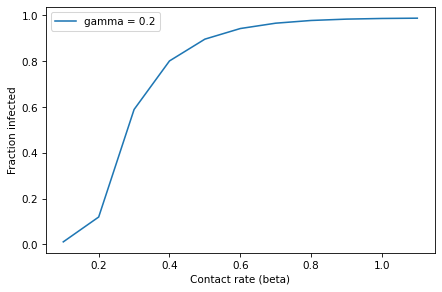

In [17]:
label = 'gamma = ' + str(gamma)
infected_sweep.plot(label=label)

decorate(xlabel='Contact rate (beta)',
         ylabel='Fraction infected')


### Sweeping gamma

Using the same array of values for `beta`

In [18]:
beta_array

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]

And now an array of values for `gamma`

In [19]:
gamma_array = [0.2, 0.4, 0.6, 0.8]

[0.2, 0.4, 0.6, 0.8]

For each value of `gamma`, sweep `beta` and plot the results.

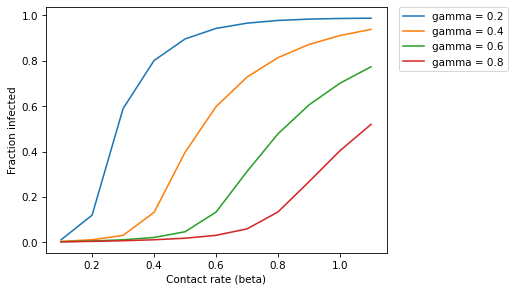

In [22]:
plt.figure(figsize=(7, 4))

for gamma in gamma_array:
    infected_sweep = sweep_beta(beta_array, gamma)
    label = 'gamma = ' + str(gamma)
    infected_sweep.plot(label=label)
    
decorate(xlabel='Contact rate (beta)',
         ylabel='Fraction infected')

plt.legend(bbox_to_anchor=(1.02, 1.02))
plt.tight_layout()

**Exercise:**  Suppose the infectious period for the Freshman Plague is known to be 2 days on average, and suppose during one particularly bad year, 40% of the class is infected at some point.  Estimate the time between contacts.

In [32]:
# Solution goes here
gamma_ex = 1/ 2
ex_infect_sweep = sweep_beta(beta_array, gamma_ex)

Parameter
0.1    0.002736
0.2    0.007235
0.3    0.015929
0.4    0.038604
0.5    0.132449
0.6    0.346766
0.7    0.530585
0.8    0.661553
0.9    0.754595
1.0    0.821534
1.1    0.870219
Name: Metric, dtype: float64

The infection rate appears to reach 40% when beta is between 0.6 and 0.7 when there is a 2 day recovery rate

In [34]:
# Solution goes here
ex_days_btw_contact = crossings(ex_infect_sweep,0.4)

array([0.62548696])

In [37]:
# Solution goes here
print(f"The number of days between contact when the recovery rate is 2 days and infection rates are 40% is: {1/ex_days_btw_contact[0]}")

The number of days between contact when the recovery rate is 2 days and infection rates are 40% is: 1.598754362761945


Approximately 1.5 days between every contact could potentially reach these infection levels based on these simulations

## SweepFrame

The following sweeps two parameters and stores the results in a `SweepFrame`

In [23]:
def sweep_parameters(beta_array, gamma_array):
    """Sweep a range of values for beta and gamma.
    
    beta_array: array of infection rates
    gamma_array: array of recovery rates
    
    returns: SweepFrame with one row for each beta
             and one column for each gamma
    """
    frame = SweepFrame(columns=gamma_array)
    for gamma in gamma_array:
        frame[gamma] = sweep_beta(beta_array, gamma)
    return frame

Here's what the `SweepFrame` look like.

In [24]:
frame = sweep_parameters(beta_array, gamma_array)
frame.head()

,0.2,0.4,0.6,0.8
Parameter,,,,
0.1,0.010756,0.003642,0.002191,0.001567
0.2,0.119332,0.010763,0.005447,0.003644
0.3,0.589215,0.030185,0.010771,0.006526
0.4,0.801340,0.131604,0.020917,0.010780
0.5,0.896577,0.396416,0.046140,0.017640


And here's how we can plot the results.

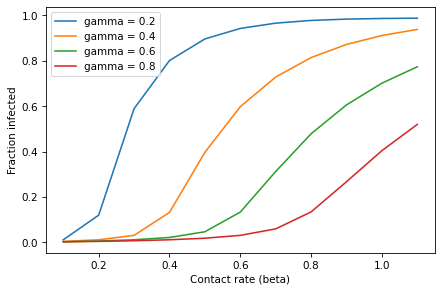

In [26]:
for gamma in gamma_array:
    label = 'gamma = ' + str(gamma)
    frame[gamma].plot(label=label)
    
decorate(xlabel='Contact rate (beta)',
         ylabel='Fraction infected',
         title='')

We can also plot one line for each value of `beta`, although there are a lot of them.

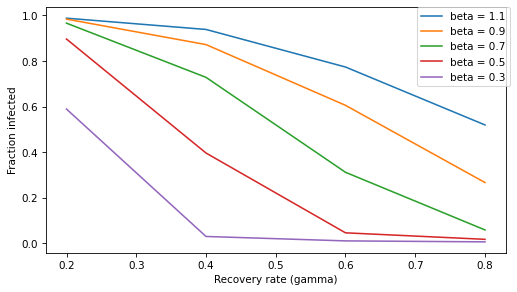

In [28]:
plt.figure(figsize=(7, 4))


for beta in [1.1, 0.9, 0.7, 0.5, 0.3]:
    label = 'beta = ' + str(beta)
    frame.loc[beta].plot(label=label)
    
decorate(xlabel='Recovery rate (gamma)',
         ylabel='Fraction infected')

plt.legend(bbox_to_anchor=(1.02, 1.02))
plt.tight_layout()

It's often useful to separate the code that generates results from the code that plots the results, so we can run the simulations once, save the results, and then use them for different analysis, visualization, etc.

After running `sweep_parameters`, we have a `SweepFrame` with one row for each value of `beta` and one column for each value of `gamma`.

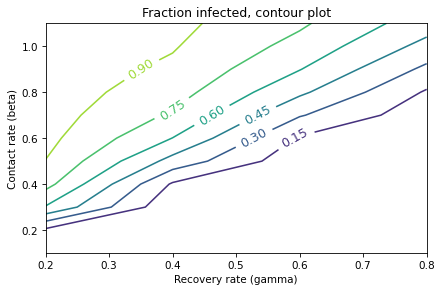

In [29]:
contour(frame)

decorate(xlabel='Recovery rate (gamma)',
         ylabel='Contact rate (beta)',
         title='Fraction infected, contour plot')